# Titanic Dataset

## Lib Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Remove warnings from workbook.

In [2]:
import warnings

warnings.simplefilter('ignore')

In [3]:
RANDOM_STATE = 123

**Custom Helper Methods**

In [29]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def replace_missing_age_values(df):
    titles = list(df['Title'].unique())
    means = [df['Title' == title].mean() for title in titles]
    mean_age_by_title = dict(zip(titles, means))
    df['Age'] = df['Age'].fillna(mean_age_by_title)

def replace_missing_fare_values(df):
    mean_fare = df['Fare'].mean()
    df['Fare'] = df['Fare'].fillna(mean_fare)

def create_titles_column(df):
    passenger_names = df['Name'].str.split(',')
    df['Title'] = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]
    df.drop('Name', inplace=True, axis=1)

def create_family_size_column(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], inplace=True, axis=1)
    
def normalize_columns(df):
    #TODO: move to ColumnTransformer class
    min_max_scaler = MinMaxScaler()
    NUMERICAL_COLUMNS = ['Age', 'Fare']
    df[NUMERICAL_COLUMNS] = min_max_scaler.fit_transform(df[NUMERICAL_COLUMNS])

def label_columns(df):
    #TODO: move to ColumnTransformer class
    label_encoder = LabelEncoder()
    df['Sex'] = label_encoder.fit_transform(df['Sex'])
    df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
    df['Title'] = label_encoder.fit_transform(df['Title'])

def drop_unnecessary_columns(df):
    COLUMNS_TO_DROP = ['PassengerId', 'Ticket', 'Cabin']
    df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

def preprocess_dataset(df):
    """_summary_

    Args:
        df (_type_): _description_
    """
    create_titles_column(df)
    create_family_size_column(df)
    replace_missing_age_values(df)
    replace_missing_fare_values(df)
    label_columns(df)
    normalize_columns(df)
    drop_unnecessary_columns(df)

## 1. Dataset Loading

In [5]:
train_df = pd.read_csv('train.csv')

**Manual replace of one variable**

During title creation and analysis, I noticed that there was on Name which did not follow the format of others and was impacting the Title extraction method, so I will manually replace it below.

In [6]:
train_df[(train_df['Name'].str.contains('the Countess. of'))]['Name']

759    Rothes, the Countess. of (Lucy Noel Martha Dye...
Name: Name, dtype: object

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print(f"Sample size: {len(train_df)}")

Sample size: 891


In [9]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dealing with a dataset with a relatively small sample size.

In [10]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
test_df = pd.read_csv('test.csv')
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 2. EDA

Three columns are missing values within the training and testing dataset:

* Age: missing alot of values which is significant as age was likely a significant factor in the survival on the Titanic.
* Cabin: missing substantial values but not likely significant so can also be removed.
* Embarked: only missing a handful of entries so can probably just be removed.

For starters I will concatenate the training and test datasets in order to get as many samples as possible to view the trends.

In [12]:
investigation_df = pd.concat([train_df.drop('Survived', axis=1), test_df])
investigation_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.1 Missing Cabin Analysis

The aim of this section is to determine if there is any viable way of filling in missing Cabin values based on other data.

In [13]:
missing_cabin_values = (investigation_df['Cabin'].isna())

I'll start by reviewing the non missing values to determine if there are any trends amongst the other variables.

In [14]:
missing_cabin_values = investigation_df[missing_cabin_values]
missing_cabin_values.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


### 2.2 Missing Age Analysis

Now I'm going to investigate the relationship between age and other variables to determine if there is a more exact way of filling in missing age data.

I'll start by plotting the distribution of age variables.

<Axes: >

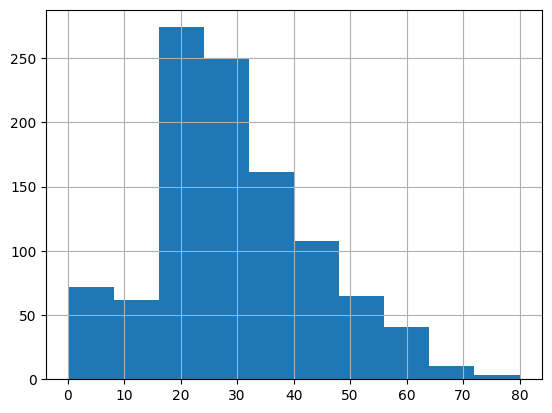

In [15]:
investigation_df['Age'].hist(bins=10)

In [16]:
investigation_df['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

I'll isolate the dataset to only include actual age values.

In [17]:
empty_age_mask = (investigation_df['Age'].isna())

In [18]:
complete_age_df = investigation_df[~empty_age_mask]
complete_age_df.drop('PassengerId', axis=1, inplace=True)
create_family_size_column(complete_age_df)
create_titles_column(complete_age_df)
label_columns(complete_age_df)
complete_age_df.head()

,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,3,1,22.0,A/5 21171,7.2500,NaN,2,1,12
1,1,0,38.0,PC 17599,71.2833,C85,0,1,13
2,3,0,26.0,STON/O2. 3101282,7.9250,NaN,2,0,9
3,1,0,35.0,113803,53.1000,C123,2,1,13
4,3,1,35.0,373450,8.0500,NaN,2,0,12


In [19]:
numerical_cols = [colname for colname in complete_age_df.columns if complete_age_df[colname].dtype != 'object']

<Axes: >

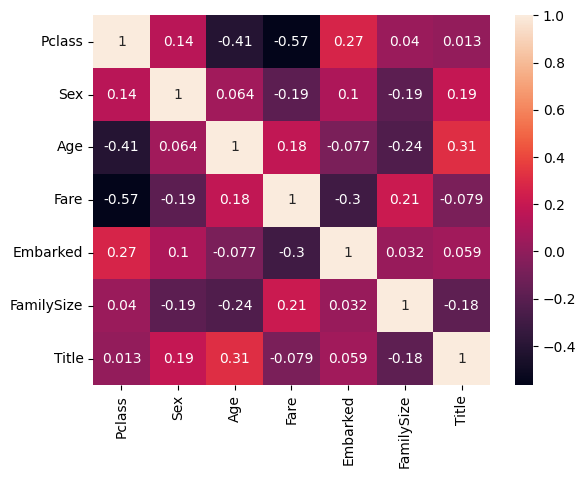

In [20]:
sns.heatmap(complete_age_df[numerical_cols].corr(), annot=True)

There are some interesting observations from the above correlation plot:

* Strong negative correlation between Pclass and Age, indicating that higher passenger classes have lower age.
* Strop positive correlation between Title and Age.

Now I will create scatter plots of Age against variables with the strongest correlations.

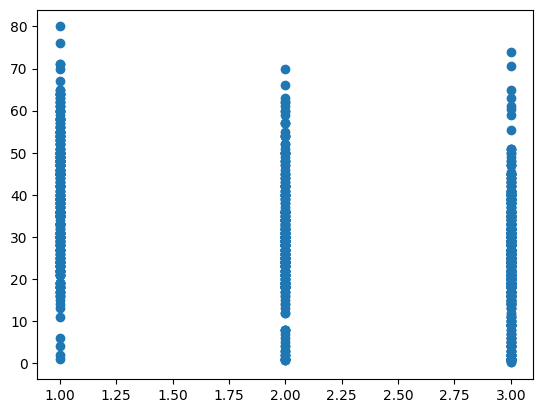

In [21]:
plt.scatter(complete_age_df['Pclass'], complete_age_df['Age'])
plt.show()

Age seems to be pretty spread across the three classes so this is of no use.

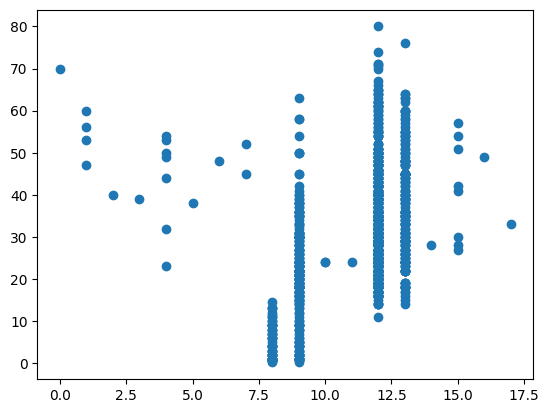

In [22]:
plt.scatter(complete_age_df['Title'], complete_age_df['Age'])
plt.show()

There does appear to be grouping around certain titles, so maybe using the mean based on title is the best way of filling in missing data.

## 3. Feature Engineering and Preprocessing

Based on discussions and research, the below features will be engineered:

* FamilySize: this represents the combination of SibSp and Parch column.
* Title: will used a refactored version of the code from 2.3 to convert names to Titles.

The below columns with be LabelEncoded:

* Title
* Sex
* Embarked

Furthermore the below columns will be dropped:

* 'PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin'

Also the training dataset is missing 2 values for Embarked, and the testing dataset is missing 1 value for Fare, so these will be dropped.

In [24]:
train_df.dropna(subset=['Embarked'], inplace=True)
test_df.dropna(subset=['Fare'], inplace=True)

In [25]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [26]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          326
Embarked         0
dtype: int64

First step is to create a dictionary containing the mean age grouped by title which will be used to replace missing ages.

Now preprocess the dataset.

In [28]:
preprocess_dataset(train_df)
train_df.head()

KeyError: 'Title'

In [ ]:
train_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64

In [ ]:
len(train_df)

891

## 4. X and y split

In [ ]:
Y_COLUMN = 'Survived'

In [ ]:
y = train_df[Y_COLUMN]
X = train_df.drop(Y_COLUMN, axis=1)

In [ ]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.271174,0.014151,2,11,1
1,1,0,0.472229,0.139136,0,12,1
2,3,0,0.321438,0.015469,2,8,0
3,1,0,0.434531,0.103644,2,12,1
4,3,1,0.434531,0.015713,2,11,0


In [ ]:
y.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## 5. Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

## 6. Model Training

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
lr_model = LogisticRegressionCV(
    Cs=8,
    penalty='l2',
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
)

In [ ]:
lr_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=8, cv=5, n_jobs=-1, random_state=123)

## 7. Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def get_classification_metrics(y_true, y_pred, name):
    return {
        'name': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
get_classification_metrics(y_test, y_pred, 'Logistic Regression')

{'name': 'Logistic Regression',
 'accuracy': 0.7947761194029851,
 'precision': np.float64(0.7311827956989247),
 'recall': np.float64(0.6938775510204082),
 'f1_score': np.float64(0.7120418848167539)}

## 8. Kaggle Prediction Generation and Submissions

The next section reads the test dataset, applies the same preprocessing as for the training set, runs predictions and reformats csv file so it can be submitted to Kaggle.

In [ ]:
X_val = test_df.copy()
preprocess_dataset(X_val)

In [ ]:
X_val.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.452723,0.015282,1,5,0
1,3,0,0.617566,0.013663,2,6,1
2,2,1,0.815377,0.018909,1,5,0
3,3,1,0.353818,0.016908,2,5,0
4,3,0,0.287881,0.023984,2,6,2


In [ ]:
y_val = lr_model.predict(X_val)

In [ ]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_val})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
submission.to_csv('submission.csv', index=False)